In [81]:
import pandas as pd
import datetime as dt
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from DLTV import df_donantes, df_transacciones, df_inflacion, lfv, donaciones_anuales
from xgboost import XGBClassifier, plot_importance
import gower
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
from kmodes.kprototypes import KPrototypes
from pca import pca
from sklearn.preprocessing import StandardScaler

### Funciones de Experimentación

In [82]:
def obtener_mejor_k(df: pd.DataFrame):
    """ Calcula el mejor número de clusters para un dataset dado
    Args:
        df (DataFrame): Dataset a utilizar
    Returns:
        int: Número de clusters óptimo"""
    df = StandardScaler().fit_transform(df)
    sil = []
    for k in range(2, 10):
        kmeans = KMeans(n_clusters = k, random_state=123).fit(df)
        labels = kmeans.labels_
        sil.append(silhouette_score(df, labels, metric = 'euclidean'))
    # Graficar silhouette_score
    fig = px.line(x = range(2, 10), y = sil)
    fig.show()
    # Crear dataframe con los valores de silhouette_score
    df_sil = pd.DataFrame({'k': range(2, 10), 'sil': sil})
    # Ordenar de mayor a menor
    df_sil = df_sil.sort_values('sil', ascending = False)
    # Obtener el mejor k
    best_k = df_sil.iloc[0, 0]
    # Si best_k = 2, tomar el segundo mejor
    if best_k == 2:
        best_k = df_sil.iloc[1, 0]
    
    print('El mejor número de clusters es: ', best_k)
    return best_k

def obtener_mejor_k_prototype(df: pd.DataFrame):
    """ Calcula el mejor número de clusters para un dataset dado
    Args:
        df (DataFrame): Dataset a utilizar
    Returns:
        None"""
    # Convertir dataframe en array
    array = df.values    

    # Obtener índices de variables categóricas
    idx = []
    for col in df.columns:
        if df[col].dtype == 'object':
            idx.append(df.columns.get_loc(col))
        else:
            array[:,df.columns.get_loc(col)] = array[:,df.columns.get_loc(col)].astype(float)

    # Calcular silhouette_score
    cost_values = []
    for k in range(2, 10):
        kprototypes = KPrototypes(n_clusters=k, init='Huang', verbose=1, max_iter=20, random_state=123)
        kprototypes.fit_predict(array, categorical=idx)
        cost_values.append(kprototypes.cost_)
    # Graficar elbow
    fig = px.line(x = range(2, 10), y = cost_values, title='Gráfica de codo')
    fig.update_xaxes(title='Número de clusters')
    fig.update_yaxes(title='Costo')
    fig.show()

def obtener_clusters_prototype(df: pd.DataFrame, cols: list, k: int):
    """ Calcula los clusters de un dataset dado
    Args:
        df (DataFrame): Dataset a utilizar
        k (int): Número de clusters
    Returns:
        DataFrame: Dataset con los clusters
        KMeans: Modelo de KMeans"""
    # Convertir dataframe en array
    array = df.values    

    # Obtener índices de variables categóricas
    idx = []
    for col in df.columns:
        if df[col].dtype == 'object':
            idx.append(df.columns.get_loc(col))
        else:
            array[:,df.columns.get_loc(col)] = array[:,df.columns.get_loc(col)].astype(float)

    # Calcular clusters
    kprototypes = KPrototypes(n_clusters=k, init='Huang', verbose=1, max_iter=20, random_state=123)
    clusters = kprototypes.fit_predict(array, categorical=idx)
    df['cluster'] = clusters
    return df, kprototypes

def obtener_clusters(df:pd.DataFrame, cols: list, k: int):
    """ Calcula los clusters de un dataset dado
    Args:
        df (DataFrame): Dataset a utilizar
        k (int): Número de clusters
    Returns:
        DataFrame: Dataset con los clusters
        KMeans: Modelo de KMeans"""
    df_copy = df[cols].copy()
    df_copy = StandardScaler().fit_transform(df_copy)
    kmeans = KMeans(n_clusters = k, n_init=10, random_state=0)
    kmeans.fit(df_copy)
    df['cluster'] = kmeans.labels_
    return df, kmeans

def graficar_clusters(df: pd.DataFrame, x: str, y: str):
    """ Grafica los clusters de un dataset dado
    Args:
        df (DataFrame): Dataset a utilizar
        x (str): Nombre de la columna x
        y (str): Nombre de la columna y
    Returns:
        None"""
    fig = px.scatter(df, x = x, y = y, color = 'cluster')
    fig.show()

def graficar_clusters3D(df: pd.DataFrame, x:str, y:str, z:str):
    """ Grafica los clusters de un dataset dado en 3D
    Args:
        df (DataFrame): Dataset a utilizar
        x (str): Nombre de la columna x
        y (str): Nombre de la columna y
        z (str): Nombre de la columna z
    Returns:
        None"""
    fig = px.scatter_3d(df, x=x, y=y, z=z, color='cluster')
    fig.show()

def graficar_importancia(df: pd.DataFrame, cols: list):
    """ Grafica la importancia de las variables de un dataset dado
    Args:
        df (DataFrame): Dataset a utilizar
        cols (list): Lista de columnas a utilizar
    Returns:
        None"""
    # Crear conjunto de entrenamiento y prueba
    X = df[cols]
    y = df['cluster']

    # Divider en datos de prueba y entrenamiento
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    model = XGBClassifier(eval_metric='mlogloss')
    # Entrenar modelo
    model.fit(X_train, y_train)
    # Predecir con datos de prueba
    y_pred = model.predict(X_test)
    # Calcular precisión del modelo
    accuracy = accuracy_score(y_test, y_pred)
    print(f'La precisión del modelo es: {accuracy}')
    # Graficar importancia de variables
    plot_importance(model)

def graficar(df: pd.DataFrame, cols: list):
    if len(cols) == 2:
        graficar_clusters(df, cols[1], cols[0])
    elif len(cols) == 3:
        graficar_clusters3D(df, cols[0], cols[1], cols[2])
    else:
        print('No se puede graficar porque son más de 3 dimensiones')

def calcular_outliers(df: pd.DataFrame, col:str):
    """ Calcula los outliers de una variable
    Args:
        df (DataFrame): Dataset a utilizar
        col (str): Nombre de la columna
    Returns:
        DataFrame: Dataset sin outliers
        DataFrame: Dataset con outliers"""
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    no_outliers = df[(df[col] >= lower) & (df[col] <= upper)]
    print(f'Se encontraron {len(outliers)} outliers en la variable {col} con un límite inferior de {lower} y un límite superior de {upper}')
    print(f'Se analizará una base con {len(no_outliers)} registros')
    return no_outliers, outliers

#### Agregar Variables

In [83]:
# Pasar columnas de fecha a formato fecha
df_donantes['DT_Captacion'] = pd.to_datetime(df_donantes['DT_Captacion'])
df_donantes['DT_Primer_Cobro'] = pd.to_datetime(df_donantes['DT_Primer_Cobro'])
# Calcular el tiempo de conversión como la diferencia entre la fecha de primer cobro y la fecha de captación
df_donantes['T_Conversion'] = df_donantes['DT_Primer_Cobro'] - df_donantes['DT_Captacion']
# Convertir el tiempo de conversión a número de días
df_donantes['T_Conversion'] = df_donantes['T_Conversion'].dt.days
# Hacer una tabla dinámica que muestre por donante en qué canal entró su donación
tipo_transacciones = df_transacciones.pivot_table(index='FK_ID_Donante', columns='FK_CD_Registro', values='VL_Importe', aggfunc='count').fillna(0)
# Calcular el número de canales por donante
tipo_transacciones['Canales_Donacion'] = tipo_transacciones.apply(lambda x: np.count_nonzero(x), axis=1)
# Calcular el canal principal de donación
tipo_transacciones['Canal_Principal'] = tipo_transacciones.apply(lambda x: x.idxmax(), axis=1)
# Agregar variables a la tabla de donantes
lfv = pd.merge(lfv, df_donantes[['ID_Donante', 'T_Conversion', 'FK_ID_Genero', 'FK_ID_Estado_Civil']], on='ID_Donante', how='left')
lfv = pd.merge(lfv, tipo_transacciones[['Canales_Donacion', 'Canal_Principal']], left_on='ID_Donante', right_on= 'FK_ID_Donante', how='left')
lfv.head()

ID_Donante   Valor_Total  Anio_Donacion  VL_Lifespan  VL_Edad  VL_NChurn   
0  1020000012  1.828684e+06           2021     6.250000       55     0.1600  \
1  1020000038  1.689828e+06           2021     4.545455       19     0.2200   
2  1020000079  2.711845e+06           2021     5.555556       63     0.1800   
3  1020000087  1.005497e+06           2021     7.142857       67     0.1400   
4  1020000095  2.231845e+06           2021     1.670844       49     0.5985   

   Prom_Cuotas_Pagadas  Prom_Cuotas_No_Pagadas  Ant_Primer_Transaccion   
0            68.000000                9.666667                       2  \
1            24.333333                4.000000                       2   
2            20.333333                1.500000                       2   
3            34.000000                4.166667                       2   
4            26.750000               20.000000                       2   

     Total_Anual          DLTV  T_Conversion FK_ID_Genero FK_ID_Estado_Civil   
0  609561.436663  2.456657e+06          3993    Masculino                  0  \
1  563275.901847  1.685644e+06          3129     Femenino                  0   
2  903948.331844  3.202134e+06          3014    Masculino             Casado   
3  335165.603701  1.495850e+06          2794    Masculino                  0   
4  743948.331844  6.600637e+05          5814     Femenino             Casado   

   Canales_Donacion             Canal_Principal  
0                 1                DI - Regular  
1                 1                DI - Regular  
2                 1                DI - Regular  
3                 1                DI - Regular  
4                 1  PI - Padrinazgo individual

#### Calcular outliers

In [71]:
# Calcular el rango IQR para la variable DLTV
donaciones_sin_outlier, outliers = calcular_outliers(lfv, 'DLTV')
donaciones_sin_outlier.head()


Se encontraron 1288 outliers en la variable DLTV con un límite inferior de -836474.8262901533 y un límite superior de 2034314.5589071112
Se analizará una base con 22855 registros


ID_Donante   Valor_Total  Anio_Donacion  VL_Lifespan  VL_Edad  VL_NChurn   
1  1020000038  1.689828e+06           2021     4.545455       19     0.2200  \
3  1020000087  1.005497e+06           2021     7.142857       67     0.1400   
4  1020000095  2.231845e+06           2021     1.670844       49     0.5985   
5  1020000152  4.789785e+05           2021     1.715266       71     0.5830   
6  1020000160  5.234709e+05           2021     4.347826       75     0.2300   

   Prom_Cuotas_Pagadas  Prom_Cuotas_No_Pagadas  Ant_Primer_Transaccion   
1            24.333333                4.000000                       2  \
3            34.000000                4.166667                       2   
4            26.750000               20.000000                       2   
5            19.333333                2.111111                       2   
6            25.555556                2.555556                       2   

     Total_Anual          DLTV  T_Conversion FK_ID_Genero FK_ID_Estado_Civil   
1  563275.901847  1.685644e+06          3129     Femenino                  0  \
3  335165.603701  1.495850e+06          2794    Masculino                  0   
4  743948.331844  6.600637e+05          5814     Femenino             Casado   
5  159659.492776  1.416569e+05          1727     Femenino            Soltero   
6  174490.312221  5.221749e+05          1727     Femenino                  0   

   Canales_Donacion             Canal_Principal  
1                 1                DI - Regular  
3                 1                DI - Regular  
4                 1  PI - Padrinazgo individual  
5                 1                DI - Regular  
6                 1                DI - Regular

#### Definición de variables a utilizar

In [84]:
# Variables a evaluar
model_cols = ['VL_Edad', 'Prom_Cuotas_Pagadas', 'Prom_Cuotas_No_Pagadas', 'Canales_Donacion', 'DLTV', 'VL_NChurn']

# Estandarizar variables
scaler = StandardScaler()
scaler.fit(donaciones_sin_outlier[model_cols])
donaciones_sin_outlier[model_cols] = scaler.transform(donaciones_sin_outlier[model_cols])

#### PCA

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed on the [6] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[3]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


[scatterd] >INFO> Hex [[0, 0, 0]] should be of type string
[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 vs PC3 with loadings.


VL_Edad  Prom_Cuotas_Pagadas  Prom_Cuotas_No_Pagadas  Canales_Donacion   
PC1  0.184869             0.351480                0.125476         -0.003636  \
PC2  0.500416             0.579437                0.505849         -0.014188   
PC3 -0.270189             0.023224                0.274688          0.922300   

         DLTV  VL_NChurn  
PC1  0.655654  -0.629798  
PC2 -0.261167   0.299239  
PC3  0.018979   0.002811

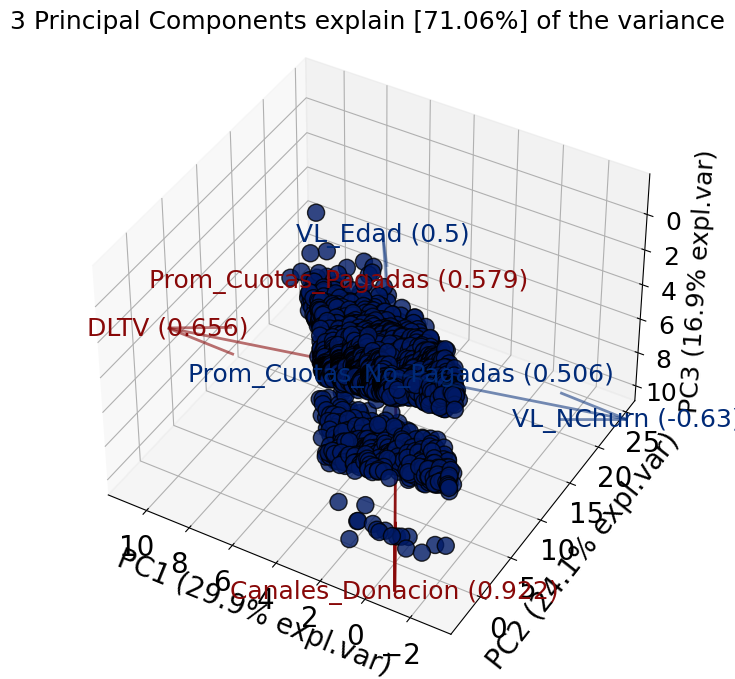

In [85]:
# Inicializar objeto PCA
pca_model = pca(n_components=3)
pca_donantes = pca_model.fit_transform(donaciones_sin_outlier[model_cols])

# Creamos el biplot
fig, ax = pca_model.biplot3d(n_feat=8, legend=False, figsize=(8,8))

display(pca_donantes['loadings'])

In [86]:
df_pca = pca_donantes['PC']
df_pca = pd.DataFrame(df_pca)
df_pca = df_pca.rename(columns={'PC1':'DV-Fuga', 'PC2':'Edad-Cuotas', 'PC3':'Canales_Donacion'})
df_pca.head()

DV-Fuga  Edad-Cuotas  Canales_Donacion
1  2.635984     0.144784          0.643517
3  3.936229     3.252972         -0.429284
4  1.545443     4.916317          1.142240
5  0.130101     2.844601         -0.789618
6  1.934578     3.128615         -0.811460

#### K-Prototypes (Para datasets con variables categóricas y numéricas al tiempo)

In [77]:
model_cols = ['DLTV', 'FK_ID_Genero', 'Canal_Principal']
obtener_mejor_k_prototype(donaciones_sin_outlier[model_cols])

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/20, moves: 1836, ncost: 12421.592213988313
Run: 1, iteration: 2/20, moves: 385, ncost: 12401.283468432744
Run: 1, iteration: 3/20, moves: 38, ncost: 12401.029351380235
Run: 1, iteration: 4/20, moves: 7, ncost: 12401.022131082313
Run: 1, iteration: 5/20, moves: 1, ncost: 12401.021946527944
Run: 1, iteration: 6/20, moves: 0, ncost: 12401.021946527944
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/20, moves: 5689, ncost: 13624.779582502973
Run: 2, iteration: 2/20, moves: 2803, ncost: 12470.249541740726
Run: 2, iteration: 3/20, moves: 712, ncost: 12402.097480808889
Run: 2, iteration: 4/20, moves: 80, ncost: 12401.041356365127
Run: 2, iteration: 5/20, moves: 12, ncost: 12401.02213108245
Run: 2, iteration: 6/20, moves: 1, ncost: 12401.021946527402
Run: 2, iteration: 7/20, moves: 0, ncost: 12401.021946527402
Init: initializing centroids
Ini

In [78]:
best_k = 4
df_segmentado, kprototypes = obtener_clusters_prototype(donaciones_sin_outlier, model_cols, best_k)
graficar(df_segmentado, model_cols)

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/20, moves: 4700, ncost: 1725535799053659.2
Run: 1, iteration: 2/20, moves: 3930, ncost: 1317526404132458.8
Run: 1, iteration: 3/20, moves: 3207, ncost: 1155607489798744.5
Run: 1, iteration: 4/20, moves: 867, ncost: 1137906731239205.2
Run: 1, iteration: 5/20, moves: 182, ncost: 1137181027181329.2
Run: 1, iteration: 6/20, moves: 32, ncost: 1137163489702655.8
Run: 1, iteration: 7/20, moves: 5, ncost: 1137163238187230.5
Run: 1, iteration: 8/20, moves: 2, ncost: 1137163109967017.2
Run: 1, iteration: 9/20, moves: 0, ncost: 1137163109967017.2
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/20, moves: 10961, ncost: 1400435946331054.8
Run: 2, iteration: 2/20, moves: 2478, ncost: 1318643205268369.2
Run: 2, iteration: 3/20, moves: 22

/var/folders/xq/zz5zb6z90_73_lf9wzs007h40000gn/T/ipykernel_48965/1977072918.py:80: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Gower para valores categoricos

In [8]:
gower_dist = gower.gower_matrix(donaciones_sin_outlier[model_cols])
gower_dist = pd.DataFrame(gower_dist)
gower_dist.head()

0         1         2         3         4         5         6      \
0  0.000000  0.364548  0.502008  0.253936  0.191353  0.342369  0.055447   
1  0.364548  0.000000  0.804127  0.556055  0.493472  0.706917  0.357565   
2  0.502008  0.804127  0.000000  0.418595  0.356012  0.177711  0.446562   
3  0.253936  0.556055  0.418595  0.000000  0.062583  0.596305  0.198490   
4  0.191353  0.493472  0.356012  0.062583  0.000000  0.533722  0.135907   

      7         8         9      ...     22831     22832     22833     22834  \
0  0.149456  0.056446  0.464625  ...  0.420667  0.595975  0.481410  0.238550   
1  0.451575  0.420994  0.100077  ...  0.722785  0.898094  0.783528  0.540669   
2  0.352552  0.558455  0.704050  ...  0.081342  0.093967  0.020598  0.403208   
3  0.104480  0.310383  0.455978  ...  0.499936  0.342039  0.439193  0.015386   
4  0.041897  0.247799  0.393395  ...  0.437353  0.404622  0.376610  0.047197   

      22835     22836     22837     22838     22839     22840  
0  0.481160  0.203047  0.147824  0.200765  0.482526  0.545861  
1  0.783278  0.505165  0.449943  0.502883  0.784644  0.847979  
2  0.020849  0.367705  0.354184  0.365423  0.019483  0.377186  
3  0.439443  0.050890  0.106112  0.053172  0.438077  0.374742  
4  0.376860  0.011693  0.043529  0.009411  0.375494  0.354508  

[5 rows x 22841 columns]

#### Cluster Jerárquico

In [10]:
Z = linkage(gower_dist, method='average', metric='euclidean')
clusters = fcluster(Z, 4, criterion='maxclust')


C:\Users\ZU956KH\AppData\Local\Temp\ipykernel_13092\3795057130.py:1: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



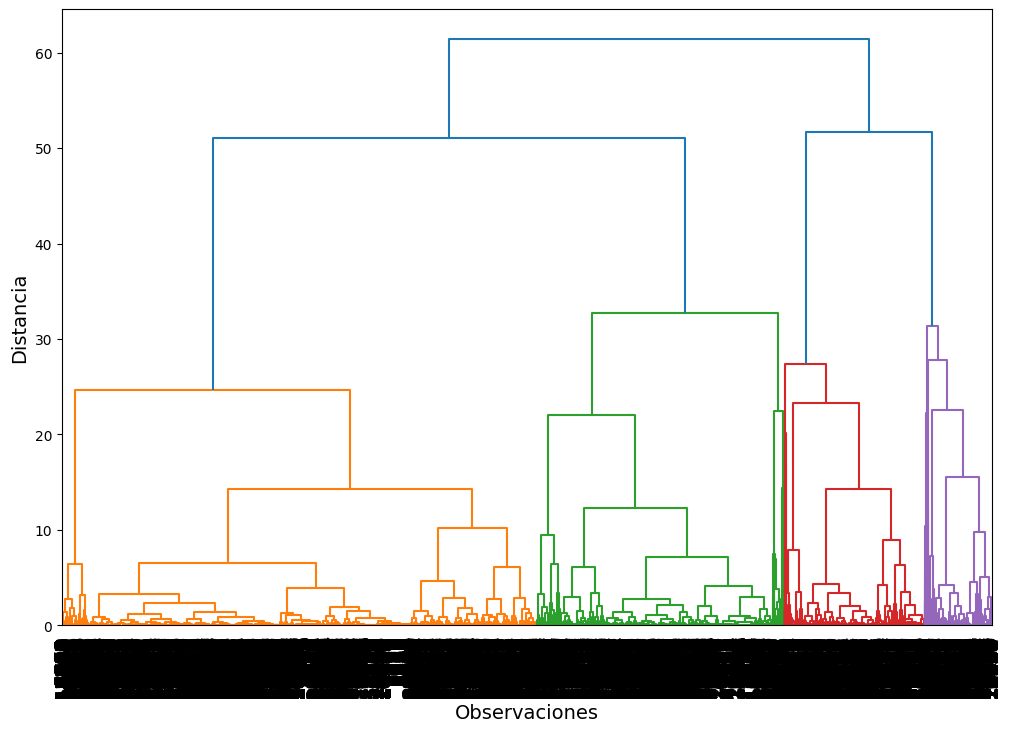

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))
d = dendrogram(Z, show_leaf_counts=True, leaf_font_size=14, ax=ax)
ax.set_xlabel('Observaciones', fontsize=14)
ax.set_yticks(np.arange(0,70,10))
ax.set_ylabel('Distancia', fontsize=14)
plt.show()

In [12]:
donaciones_sin_outlier['cluster'] = clusters

C:\Users\ZU956KH\AppData\Local\Temp\ipykernel_13092\3071126646.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [13]:
graficar(donaciones_sin_outlier, model_cols)

#### Calcular número de segmentos (K-Means)

In [79]:
# Calcular los k segmentos
#best_k = obtener_mejor_k(donaciones_sin_outlier[model_cols])
best_k = obtener_mejor_k(df_pca)

/Users/gabrielgomez/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/gabrielgomez/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/gabrielgomez/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/gabrielgomez/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/gabrielgomez/Library/Pyth

El mejor número de clusters es:  4


In [80]:
# Obtener clusters
# df_segmentado, kmeans_model = obtener_clusters(donaciones_sin_outlier, model_cols, best_k)
model_cols = df_pca.columns
df_segmentado, kmeans_model = obtener_clusters(df_pca, model_cols, best_k)
graficar(df_segmentado, model_cols)

#### Clasificar outliers

In [22]:
# Obtener clusters
df_segmentado, kmeans_model = obtener_clusters(donaciones_sin_outlier, model_cols, best_k)
# Agregar clasificación de outliers al df de outliers
outliers['cluster'] = kmeans_model.predict(outliers[model_cols])
# Agregar outliers al df_segmentado
df_segmentado_con_outliers = pd.concat([df_segmentado, outliers])

C:\Users\ZU956KH\AppData\Local\Temp\ipykernel_21088\3343589301.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ZU956KH\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:443: UserWarning:

X has feature names, but KMeans was fitted without feature names

C:\Users\ZU956KH\AppData\Local\Temp\ipykernel_21088\255307455.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Graficar Segmentos

La precisión del modelo es: 0.9977228936766509


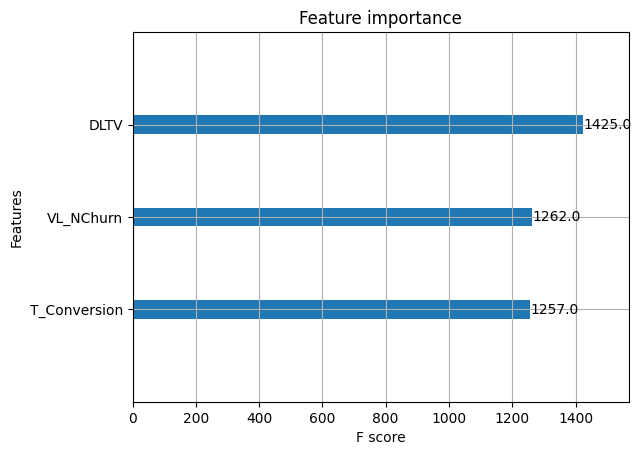

In [25]:
graficar(df_segmentado, model_cols)
graficar_importancia(df_segmentado, model_cols)

#### Caracterizar Segmentos

In [16]:
# suppress scientific notation by setting float_format
pd.options.display.float_format = '{:.2f}'.format
# Mostrar estadísticas de los clusters
df_segmentado[model_cols+['cluster']].groupby('cluster').describe().T

cluster                        0          1          2          3          4
DLTV             count  13850.00     881.00    5218.00     593.00    2299.00
                 mean  344646.11  670359.42 1274611.73  992081.42  638533.26
                 std   194479.95  528205.06  332842.94  534288.81  382719.12
                 min    10114.55   33305.11  801040.39   44695.73   17715.27
                 25%   189498.43  237486.25  949251.68  562496.64  353810.91
                 50%   300758.51  496981.32 1204231.32  946007.82  567604.69
                 75%   518816.54 1056505.01 1510294.24 1380152.02  845456.58
                 max   810660.63 2036851.85 2036757.57 2028848.31 1930289.33
T_Conversion     count  13850.00     881.00    5218.00     593.00    2299.00
                 mean      64.40     274.96     104.50    3274.83    1457.22
                 std      137.44     625.59     258.73     701.98     427.33
                 min     -318.00    -426.00    -318.00    2030.00     638.00
                 25%        9.00       6.00       9.00    2782.00    1096.50
                 50%       22.00      22.00      23.00    3131.00    1428.00
                 75%       45.00      74.00      45.00    3767.00    1727.00
                 max      923.00    3774.00    1755.00    6492.00    2649.00
Canales_Donacion count  13850.00     881.00    5218.00     593.00    2299.00
                 mean       1.00       2.02       1.00       1.03       1.00
                 std        0.00       0.14       0.00       0.16       0.00
                 min        1.00       2.00       1.00       1.00       1.00
                 25%        1.00       2.00       1.00       1.00       1.00
                 50%        1.00       2.00       1.00       1.00       1.00
                 75%        1.00       2.00       1.00       1.00       1.00
                 max        1.00       3.00       1.00       2.00       1.00